# Importación de módulos generales

In [1]:
%pylab inline
%load_ext memory_profiler

# %pylab

import os
import tempfile
import pandas as pd
# import numpy as np
import networkx as nx
# import matplotlib
# import pylab  as plt
import pygraphviz

from pomegranate import BayesianNetwork

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

Populating the interactive namespace from numpy and matplotlib


# Funciones auxiliares visualización

Importamos las funciones auxiliares para visualizar redes que hemos definido:
- **plot_pomegranate_bn_nx**(pgm, layout=None, node_size=2000, node_color='pink')
- **plot_pomegranate_bn_pgvz**(pgm, filename=None, prog='dot', color='red')
- **plot_pgm_bn**(pgm, layout=None, node_size=2000, node_color='pink'):

In [2]:
from funciones_auxiliares import *

# Lectura de datos

Podemos obtener los datos originales de https://www.kaggle.com/uciml/pima-indians-diabetes-database.

In [3]:
data = pd.read_csv("data/diabetes/prima_indian_diabetes_dataset.csv")
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Como podemos observar, hay valores nulos en ciertas variables, en este caso representados mediante el valor 0.

In [4]:
data [['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = data[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)
print("Valores nulos en cada variable:\n", data.isnull().sum())

print("\nNúmero de registros completos: ", data.dropna().count()[0])

Valores nulos en cada variable:
 Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

Número de registros completos:  392


Discretizamos las variables numéricas:

In [5]:
columns_to_discretize = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
num_bins=15

for col in columns_to_discretize:
    data[col] = pd.cut(data[col], bins=num_bins)
    
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,"(147.333, 157.667]","(69.733, 76.267]","(31.533, 37.667]",NaN,"(31.24, 34.5]","(0.546, 0.703]","(49.0, 53.0]",1
1,1,"(75.0, 85.333]","(63.2, 69.733]","(25.4, 31.533]",NaN,"(24.72, 27.98]","(0.234, 0.39]","(29.0, 33.0]",0
2,8,"(178.333, 188.667]","(63.2, 69.733]",NaN,NaN,"(21.46, 24.72]","(0.546, 0.703]","(29.0, 33.0]",1
3,1,"(85.333, 95.667]","(63.2, 69.733]","(19.267, 25.4]","(69.467, 124.933]","(27.98, 31.24]","(0.0757, 0.234]","(20.94, 25.0]",0
4,0,"(126.667, 137.0]","(37.067, 43.6]","(31.533, 37.667]","(124.933, 180.4]","(41.02, 44.28]","(2.264, 2.42]","(29.0, 33.0]",1


Y separamos los registros completos(sin valores nulos) de los iniciales

In [6]:
complete_data = data.dropna().reset_index(drop=True)

Dividimos los datos en conjunto de entrenamiento y validación

In [7]:
X = data.drop(columns=['Outcome'])
y = data.Outcome

X_complete = complete_data.drop(columns=['Outcome'])
y_complete = complete_data.Outcome

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3)
X_complete_train, X_complete_test, y_complete_train, y_complete_test = train_test_split(X_complete, y_complete, test_size=1/3)

print("Particiones obtenidas sobre los datos iniciales:")
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test:  ", X_test.shape)
print("y_test:  ", y_test.shape)
print("\nParticiones obtenidas sobre los datos con los registros completos:")
print("X_complete_train: ", X_complete_train.shape)
print("y_complete_train: ", y_complete_train.shape)
print("X_complete_test:  ", X_complete_test.shape)
print("y_complete_test:  ", y_complete_test.shape)

Particiones obtenidas sobre los datos iniciales:
X_train:  (512, 8)
y_train:  (512,)
X_test:   (256, 8)
y_test:   (256,)

Particiones obtenidas sobre los datos con los registros completos:
X_complete_train:  (261, 8)
y_complete_train:  (261,)
X_complete_test:   (131, 8)
y_complete_test:   (131,)


# Algoritmos de aprendizaje

### Chow-Liu

Aplicamos el algoritmo de Chow-Liu para aprender una estructura de árbol:

In [13]:
%time %memit pomegranate_tree = BayesianNetwork.from_samples(complete_data, algorithm='chow-liu', root=8, \
                                                             state_names=list(data))

pomegranate_tree.bake()

peak memory: 139.30 MiB, increment: 0.12 MiB
Wall time: 2.23 s


Visualizamos el árbol resultante:

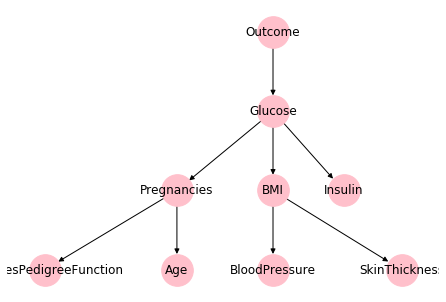

In [14]:
plot_pomegranate_bn_nx(pomegranate_tree, node_size=1000, node_color='pink')

Podemos hacer inferencia, predeciendo la variabel *Outcome* para los registros de entrenamiento:

In [15]:
nan_vec = np.array([[np.NaN]*X_complete_train.shape[0]]).T
complete_train_uknown_outcome = np.concatenate((X_complete_train.to_numpy(),nan_vec), axis=1)

%time %memit y_pred_train = np.array(pomegranate_tree.predict(complete_train_uknown_outcome))[:,8]

peak memory: 139.41 MiB, increment: 0.00 MiB
Wall time: 4.63 s


In [16]:
print(classification_report(list(y_pred_train), list(y_complete_train)))
print(accuracy_score(list(y_pred_train), list(y_complete_train)))

              precision    recall  f1-score   support

           0       0.89      0.80      0.84       203
           1       0.49      0.66      0.56        58

    accuracy                           0.77       261
   macro avg       0.69      0.73      0.70       261
weighted avg       0.80      0.77      0.78       261

0.7701149425287356


O sobre el dataset dejado en la partición para validación:

In [17]:
nan_vec = np.array([[np.NaN]*X_complete_test.shape[0]]).T
complete_data_matrix_uknown_outcome = np.concatenate((X_complete_test.to_numpy(),nan_vec), axis=1)

%time %memit y_pred = np.array(pomegranate_tree.predict(complete_data_matrix_uknown_outcome))[:,8]

peak memory: 139.39 MiB, increment: 0.00 MiB
Wall time: 2.95 s


In [18]:
print(classification_report(list(y_pred), list(y_complete_test)))
print(accuracy_score(list(y_pred), list(y_complete_test)))

              precision    recall  f1-score   support

           0       0.96      0.73      0.83       104
           1       0.46      0.89      0.61        27

    accuracy                           0.76       131
   macro avg       0.71      0.81      0.72       131
weighted avg       0.86      0.76      0.78       131

0.7633587786259542


# Comparación Chow-Liu vs Greedy vs Exact

In [19]:
%time %memit chow_liu_model = BayesianNetwork.from_samples(complete_data, algorithm='chow-liu', root=8, \
                                                             state_names=list(data))
%time %memit greedy_model = BayesianNetwork.from_samples(data, algorithm='greedy', state_names=list(data))
%time %memit exact_model = BayesianNetwork.from_samples(data, algorithm='exact', state_names=list(data))

chow_liu_model.bake()
greedy_model.bake()
exact_model.bake()

peak memory: 140.26 MiB, increment: 0.88 MiB
Wall time: 2.42 s
peak memory: 211.03 MiB, increment: 70.77 MiB
Wall time: 6.14 s
peak memory: 217.14 MiB, increment: 76.68 MiB
Wall time: 29.8 s


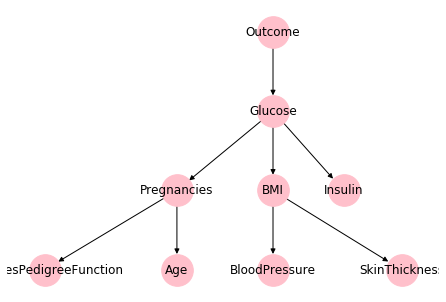

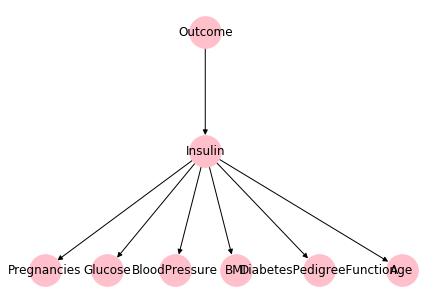

C:\Users\usuario\.conda\envs\PGM\lib\site-packages\networkx\drawing\layout.py:950: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.row_stack((pos[x] for x in node_list))


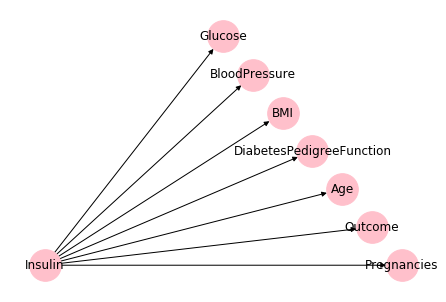

In [20]:
plot_pomegranate_bn_nx(chow_liu_model, node_size=1000, node_color='pink')
plot_pomegranate_bn_nx(greedy_model, node_size=1000, node_color='pink')
plot_pomegranate_bn_nx(exact_model, layout=nx.planar_layout, node_size=1000, node_color='pink')

In [21]:
nan_vec = np.array([[np.NaN]*X_complete_test.shape[0]]).T
complete_data_matrix_uknown_outcome = np.concatenate((X_complete_test.to_numpy(),nan_vec), axis=1)

%time %memit y_pred_complete_chow_liu = np.array(chow_liu_model.predict(complete_data_matrix_uknown_outcome))[:,8]

nan_vec = np.array([[np.NaN]*X_test.shape[0]]).T
data_matrix_uknown_outcome = np.concatenate((X_test.to_numpy(),nan_vec), axis=1)

# %time %memit y_pred_chow_liu = np.array(chow_liu_model.predict(data_matrix_uknown_outcome))[:,8]
%time %memit y_pred_greedy = np.array(greedy_model.predict(data_matrix_uknown_outcome))[:,8]
%time %memit y_pred_exact = np.array(exact_model.predict(data_matrix_uknown_outcome))[:,8]

peak memory: 141.63 MiB, increment: 0.03 MiB
Wall time: 2.8 s
peak memory: 141.92 MiB, increment: 0.27 MiB
Wall time: 6.37 s
peak memory: 142.20 MiB, increment: 0.25 MiB
Wall time: 6.41 s


In [22]:
print("Chow-Liu:\n", classification_report(list(y_pred_complete_chow_liu), list(y_complete_test)))
# print(classification_report(list(y_pred_chow_liu), list(y_test)))
print("Greedy:\n", classification_report(list(y_pred_greedy), list(y_test)))
print("Exact:\n", classification_report(list(y_pred_exact), list(y_test)))

Chow-Liu:
               precision    recall  f1-score   support

           0       0.96      0.73      0.83       104
           1       0.46      0.89      0.61        27

    accuracy                           0.76       131
   macro avg       0.71      0.81      0.72       131
weighted avg       0.86      0.76      0.78       131

Greedy:
               precision    recall  f1-score   support

           0       0.76      0.71      0.73       180
           1       0.40      0.46      0.43        76

    accuracy                           0.64       256
   macro avg       0.58      0.59      0.58       256
weighted avg       0.65      0.64      0.64       256

Exact:
               precision    recall  f1-score   support

           0       0.96      0.69      0.80       236
           1       0.16      0.70      0.26        20

    accuracy                           0.69       256
   macro avg       0.56      0.70      0.53       256
weighted avg       0.90      0.69      0.76   